In [14]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.gofplots import qqplot
import seaborn as sns
from fancyimpute import IterativeImputer
from IPython.display import display
from scipy.stats import zscore
from scipy.stats import norm


from sys import path # modificar la lista de rutas de búsqueda que el intérprete de Python utiliza para buscar módulos y paquetes.
import os # interactua con el sistema operativo
for dirname, _, filenames in os.walk('../resources/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
path.append(os.path.realpath('../'))

from custom import funtions

../resources/allColProSol.xlsx
../resources/dataset_a_2021.csv
../resources/dataset_a_2021v1.xlsx
../resources/dataset_unab_ORIGINAL SIN P1.csv
../resources/dataset_unab_P1.csv
../resources/exitoFallidoEnviosProgramaSol.xlsx
../resources/exitosoFallidosEnviosAllColProSol.xlsx
../resources/exitosoFallidosEnviosAllColSol.xlsx
../resources/exitososFallidosEnviosSol.xlsx
../resources/sinColCeroExitosoFallidosEnviosSol.xlsx


In [15]:
df = pd.read_excel(open('../resources/exitososFallidosEnviosSol.xlsx','rb'))
df.head()

,exitosos,fallidos,envios,sol1
0,10,21,31,1.0
1,7,9,16,1.0
2,6,10,16,1.0
3,0,0,0,1.0
4,0,0,0,1.0


In [16]:
df['aprobado']=df.apply(lambda x: funtions.set_in_aprobado_nota(x['sol1']),axis = 1 )
print(df.columns)

Index(['exitosos', 'fallidos', 'envios', 'sol1', 'aprobado'], dtype='object')


In [17]:
# Dimensión del conjunto de datos
df.shape

(839, 5)

In [18]:
# Imprimir los n valores primeros segun su relevancia
df.tail()

,exitosos,fallidos,envios,sol1,aprobado
834,11,5,16,7.0,1
835,9,7,16,7.0,1
836,11,20,31,7.0,1
837,16,15,31,7.0,1
838,2,29,31,7.0,1


In [19]:
# Imprimir la informacion de los datos.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 839 entries, 0 to 838
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   exitosos  839 non-null    int64  
 1   fallidos  839 non-null    int64  
 2   envios    839 non-null    int64  
 3   sol1      839 non-null    float64
 4   aprobado  839 non-null    int64  
dtypes: float64(1), int64(4)
memory usage: 32.9 KB


<Axes: >

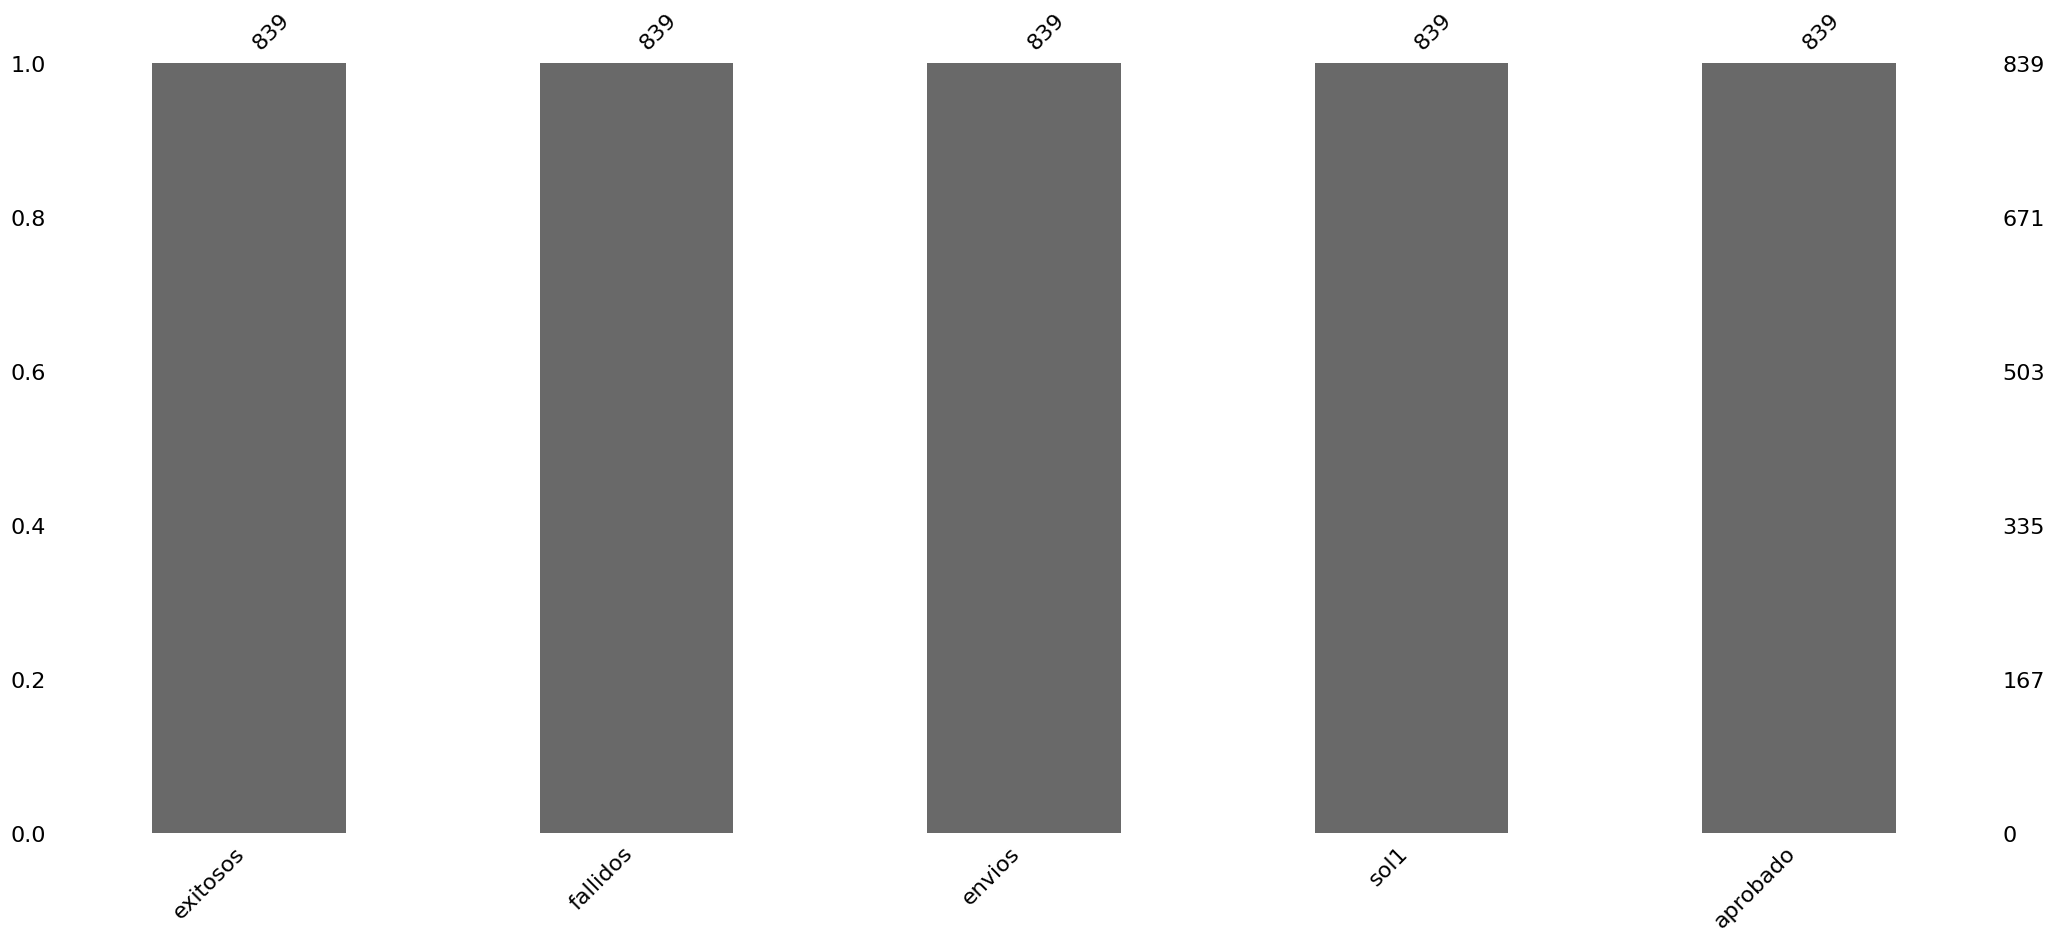

In [20]:
#Visualización de datos faltantes
msno.bar(df)


In [21]:
# Coeficiente de asimetría
def c_skew(x):
    m3 = np.mean((x - np.mean(x, axis=0)) ** 3, axis=0)
    skew = m3 / (np.std(x, axis=0) ** 3)
    skew_percent = skew * 100
    return skew, skew_percent
skewness, skewness_percent = c_skew(df['exitosos'])
print("Coeficiente de asimetría:", skewness)
print("Coeficiente de asimetría en porcentaje: {:.2f}%".format(skewness_percent))

Coeficiente de asimetría: 0.18644798387069741
Coeficiente de asimetría en porcentaje: 18.64%


In [22]:
# Coeficiente de variación
def coef_var(x):
    std = np.std(x, axis=0)
    mean = np.mean(x, axis=0)
    cv = std / mean
    cv_percent = cv * 100
    return cv, cv_percent

cv, cv_percent = coef_var(df['exitosos'])
print("Coeficiente de variación:", cv)
print("Coeficiente de variación en porcentaje: {:.2f}%".format(cv_percent))

Coeficiente de variación: 0.7166080688736847
Coeficiente de variación en porcentaje: 71.66%


In [23]:
# Eliminar filas con valores faltantes
data2 = df.dropna()

In [24]:
# Tabla de frecuencias
n = len(data2['exitosos'])
amplitud = (np.nanmax(data2['exitosos']) - np.nanmin(data2['exitosos'])) / (1 + 3.322 * np.log10(n))
data2['exitosos.cut'] = pd.cut(data2['exitosos'], bins=np.arange(0, 7.56, 0.56))
f_i = data2['exitosos.cut'].value_counts().sort_index().values
F_i = f_i.cumsum()
h_i = f_i / len(data2['exitosos'])
H_i = F_i / len(data2['exitosos'])

table = pd.DataFrame({'f_i': f_i, 'F_i': F_i, 'h_i': h_i, 'H_i': H_i}, index=data2['exitosos.cut'].value_counts().sort_index().index)
display(table)


,f_i,F_i,h_i,H_i
"(0.0, 0.56]",0,0,0.000000,0.000000
"(0.56, 1.12]",9,9,0.010727,0.010727
"(1.12, 1.68]",0,9,0.000000,0.010727
"(1.68, 2.24]",15,24,0.017878,0.028605
"(2.24, 2.8]",0,24,0.000000,0.028605
"(2.8, 3.36]",29,53,0.034565,0.063170
"(3.36, 3.92]",0,53,0.000000,0.063170
"(3.92, 4.48]",28,81,0.033373,0.096544
"(4.48, 5.04]",39,120,0.046484,0.143027
"(5.04, 5.6]",0,120,0.000000,0.143027


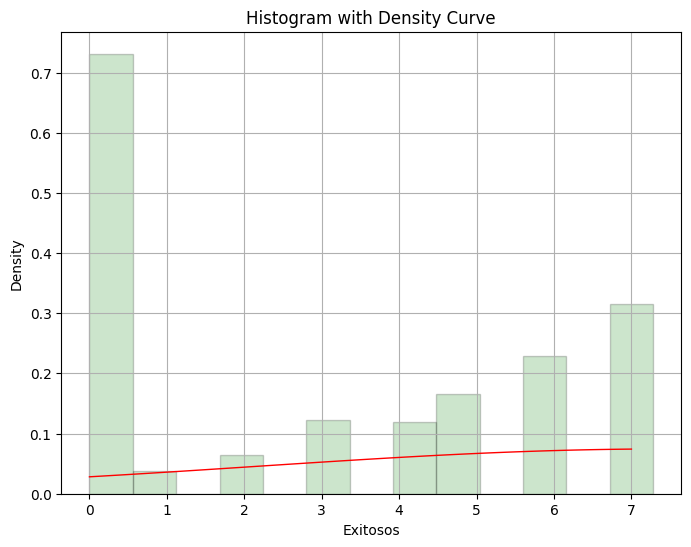

In [25]:
# Histograma con curva de densidad
plt.figure(figsize=(8, 6))
plt.hist(data2['exitosos'], bins=np.arange(0, 7.56, 0.56), density=True, color='green', alpha=0.2, edgecolor='black')
mu = np.mean(data2['exitosos'])
sigma = np.std(data2['exitosos'])
x = np.linspace(0, 7, 100)
plt.plot(x, norm.pdf(x, mu, sigma), color='red', linewidth=1)
plt.xlabel('Exitosos')
plt.ylabel('Density')
plt.title('Histogram with Density Curve')
plt.grid(True)
plt.show()

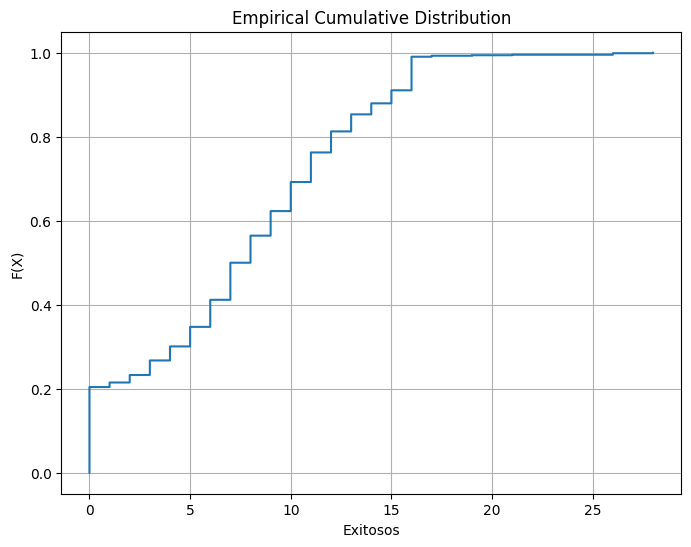

In [26]:
# Distribución empírica acumulada
plt.figure(figsize=(8, 6))
plt.step(np.sort(data2['exitosos']), np.arange(1, len(data2['exitosos']) + 1) / len(data2['exitosos']), where='post')
plt.xlabel('Exitosos')
plt.ylabel('F(X)')
plt.title('Empirical Cumulative Distribution')
plt.grid(True)
plt.show()

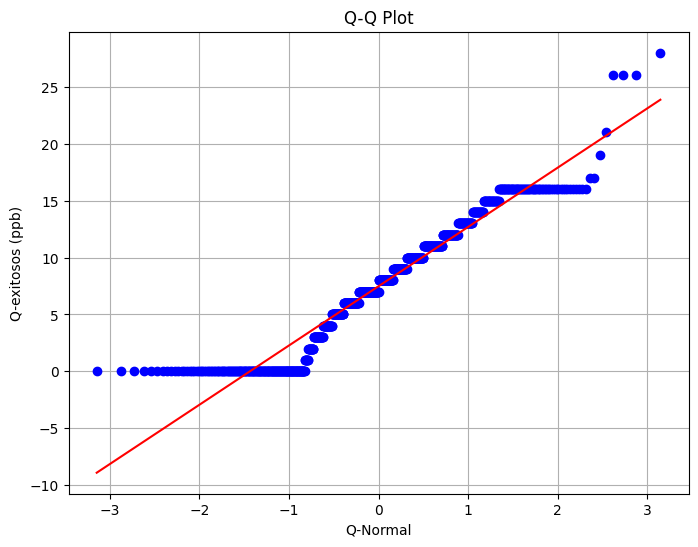

In [27]:
# Q-Q plot
plt.figure(figsize=(8, 6))
stats.probplot(data2['exitosos'], dist="norm", plot=plt)
plt.xlabel('Q-Normal')
plt.ylabel('Q-exitosos (ppb)')
plt.title('Q-Q Plot')
plt.grid(True)
plt.show()

In [28]:
# Prueba de normalidad
kstest_result = stats.kstest(data2['exitosos'], 'norm', args=(np.mean(data2['exitosos']), np.std(data2['exitosos'])))
shapiro_result = stats.shapiro(data2['exitosos'])
display('KS test p-value:', kstest_result.pvalue)
display('Shapiro-Wilk test p-value:', shapiro_result.pvalue)

'KS test p-value:'

1.2669593389493134e-11

'Shapiro-Wilk test p-value:'

3.7425708232803545e-18

In [29]:
# Calcular estadísticos descriptivos
stats = df.describe()

# Calcular límites para detectar valores atípicos (ejemplo: utilizando el rango intercuartil)
Q1 = stats.loc['25%']
Q3 = stats.loc['75%']
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identificar valores atípicos
outliers = df[(df < lower_bound) | (df > upper_bound)]
display(outliers)

,exitosos,fallidos,envios,sol1,aprobado
0,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...
834,NaN,NaN,NaN,NaN,NaN
835,NaN,NaN,NaN,NaN,NaN
836,NaN,NaN,NaN,NaN,NaN
837,NaN,NaN,NaN,NaN,NaN


In [30]:
# Calcular el Z-score de cada observación
z_scores = zscore(df)

# Establecer un umbral para detectar valores atípicos (ejemplo: umbral de 3 desviaciones estándar)
threshold = 3

# Identificar valores atípicos
outliers = df[(z_scores > threshold).any(axis=1)]
display(outliers)

,exitosos,fallidos,envios,sol1,aprobado
156,6,41,47,1.5,0
163,0,47,47,1.6,0
164,9,38,47,1.6,0
249,9,38,47,2.4,0
262,26,37,63,2.5,0
370,26,5,31,3.4,0
514,7,40,47,4.3,1
523,28,35,63,4.4,1
542,26,5,31,4.6,1
829,5,42,47,7.0,1


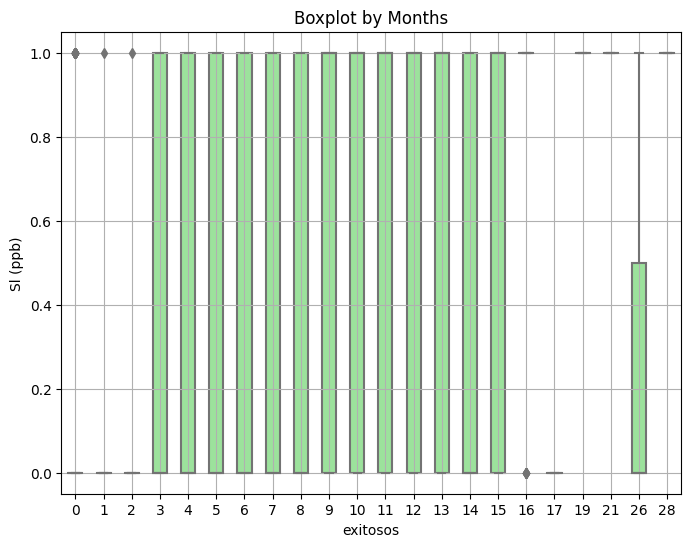

In [31]:
# Boxplot por meses
plt.figure(figsize=(8, 6))
sns.boxplot(data=data2, x='exitosos', y='aprobado', color='lightgreen', width=0.5)
plt.xlabel('exitosos')
plt.ylabel('Sl (ppb)')
plt.title('Boxplot by Months')
plt.grid(True)
plt.show()

In [32]:
# Análisis e imputación de datos faltantes
missing_data = data2.isnull().sum()
missing_data_table = pd.DataFrame({'Variable': missing_data.index, 'Missing Count': missing_data.values})
display(missing_data_table)

,Variable,Missing Count
0,exitosos,0
1,fallidos,0
2,envios,0
3,sol1,0
4,aprobado,0
5,exitosos.cut,591


In [33]:
# Imputar valores perdidos con la estrategia del promedio
df_imputed = df.fillna(df.mean())
display(df_imputed)

,exitosos,fallidos,envios,sol1,aprobado
0,10,21,31,1.0,0
1,7,9,16,1.0,0
2,6,10,16,1.0,0
3,0,0,0,1.0,0
4,0,0,0,1.0,0
...,...,...,...,...,...
834,11,5,16,7.0,1
835,9,7,16,7.0,1
836,11,20,31,7.0,1
837,16,15,31,7.0,1
